# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import os
import pandas as pd
import pickle
import itertools
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
import matplotlib.pyplot as plt
from lib.summary import load_condensed_summary

In [81]:
commithash = '9ee166f'

# SPECT tracing


In [ ]:
def plot_spect_tracing(*, country, area, ymax, ps_adoption, beta_dispersions, commithash=None):
    
    if commithash:
        commitstr = f'-{commithash}'
    else:
        commitstr = ''
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'spect-tracing-beta_dispersion={beta_dispersion}' : [
            Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                path=(f'spect-tracing-{country}-{area}{commitstr}/'
                      f'spect-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beta_dispersion={beta_dispersion}.pk'))
            for p_adoption in ps_adoption
        ]
        for beta_dispersion in beta_dispersions
    }
    
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_quantity(
            paths, 
            titles=labels,
            quantity='infected',     # Allowed values: ['infected', 'hosp', 'dead']
            mode='total',            # Allowed values: ['total', 'daily', 'cumulative']
            filename=plot_filename, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True)

ymax = {'CH' : {'TI': 100, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 17000, 'KL': 2000, 'RH': 3500}}
        
plot_spect_tracing(
    country='GER', 
    area='TU', 
    ymax=ymax, 
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05, 0.0],
    beta_dispersions=[1.0],
    commithash=commithash
)
        

In [ ]:
def plot_spect_tracing_rt(*, country, area, ps_adoption, beta_dispersion, plot_rt=True, plot_pmf=False, commithash='c005255'):
    if commithash:
        commitstr = f'-{commithash}'
    else:
        commitstr = ''
        
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'spect-tracing-p_adoption={p_adoption}' : [
            Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                path=(f'spect-tracing-{country}-{area}{commitstr}/'
                      f'spect-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beta_dispersion={beta_dispersion}.pk'))
        ]
        for p_adoption in ps_adoption
    }
    
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')
        path = paths[0]
        
        # plot
        plotter = Plotter()
        plotter.plot_daily_nbinom_rts(
            path=path, 
            filename=plot_filename,
            cmap_range=(0.5, 1.5),
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            ymax=3.3,
            xlim=(0, 127),
            x_axis_dates=False,
            subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
        )
        
        nbinom_label_range = ['tracing']
        plotter.plot_nbinom_distributions(
            path=path,
            ymax=0.85,
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            label_range=nbinom_label_range,
            filename=plot_filename,
            acc=500,
        )

          
              
plot_spect_tracing_rt(
    country='GER', 
    area='TU', 
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05, 0.0],
    beta_dispersion=1.0,
    plot_rt=True, 
    plot_pmf=False,
    commithash=commithash
)

# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

# PanCast tracing


In [ ]:
def plot_beacon_pancast_tracing(*, country, area, ymax, 
    ps_adoption, beacon_proportions, beacon_mode, p_recall, p_willing_to_share, beta_dispersion, commithash=None):
    
    if commithash:
        commitstr = f'-{commithash}'
    else:
        commitstr = ''
    
    
    normalization_baseline_path = (f'spect-tracing-{country}-{area}{commitstr}/'
                                  f'spect-tracing-{country}-{area}-p_adoption=0.0-beta_dispersion=1.0.pk')
    
    # Adoption lines given `beacon_proportion` 
    plots = {
        
        (f'pancast-tracing' 
          f'-beacon_proportion={beacon_proportion}'
        )
        : [
            Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                path=(f'pancast-tracing-{country}-{area}{commitstr}/'
                      f'pancast-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-p_recall={p_recall}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-beta_dispersion={beta_dispersion}'
                      '.pk'))
            for p_adoption in ps_adoption
        ]
        for beacon_proportion in beacon_proportions
    }
        
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_quantity(
            paths, 
            titles=labels,
            quantity='hosp',     # Allowed values: ['infected', 'hosp', 'dead']
            mode='total',            # Allowed values: ['total', 'daily', 'cumulative']
            normalization_baseline_path = normalization_baseline_path,
            filename=plot_filename, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True)

ymax = {'CH' : {'TI': 100, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 17000, 'KL': 2000, 'RH': 3500}}
        
plot_beacon_pancast_tracing(
    country='GER', 
    area='TU', 
    ymax=ymax, 
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
    beacon_proportions=[1.0],#, 0.25, 0.1, 0.05, 0.02],
    beta_dispersion=1.0,
    beacon_mode='visit_freq',
    p_recall=0.1,
    p_willing_to_share=1.0,
    commithash=commithash
)
        

In [ ]:
def plot_pancast_tracing_rt(*, country, area, ps_adoption, beta_dispersion, beacon_proportions,
                            beacon_mode, p_recall, plot_rt=True, plot_pmf=False, commithash=None):
    
    if commithash:
        commitstr = f'-{commithash}'
    else:
        commitstr = ''
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
    
        (f'pancast-tracing' 
          f'-beacon_proportion={beacon_proportion}-p_adoption={p_adoption}'
        )
        : [
            Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                path=(f'pancast-tracing-{country}-{area}{commitstr}/'
                      f'pancast-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-p_recall={p_recall}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-beta_dispersion={beta_dispersion}'
                      '.pk'))
        ]
        for beacon_proportion, p_adoption in itertools.product(beacon_proportions, ps_adoption)
    }
    
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')
        path = paths[0]
        
        # plot
        plotter = Plotter()
        plotter.plot_daily_nbinom_rts(
            path=path, 
            filename=plot_filename,
            cmap_range=(0.5, 1.5),
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            ymax=3.3,
            xlim=(0, 127),
            x_axis_dates=False,
            subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
        )
        
        nbinom_label_range = ['tracing']
        plotter.plot_nbinom_distributions(
            path=path,
            ymax=0.85,
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            label_range=nbinom_label_range,
            filename=plot_filename,
            acc=500,
        )

          
              
plot_pancast_tracing_rt(
    country='GER', 
    area='TU', 
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beta_dispersion=1.0,
    beacon_proportions=[0.25],
    beacon_mode='visit_freq',
    p_recall=0.1,
    plot_rt=True, 
    plot_pmf=False,
    commithash=commithash
)

# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

# PanCast tracing at sparse locations


In [ ]:
def plot_beacon_pancast_tracing_sparse(*, country, area, ymax, 
    ps_adoption, beacon_proportions, beacon_mode, p_recall, beta_dispersion, commithash=None):
    
    if commithash:
        commitstr = f'-{commithash}'
    else:
        commitstr = ''
    
    # beacon_proportion lines given adoption 
    plots = {
        
        (f'pancast-tracing' 
          f'-p_adoption={p_adoption}'
          f'-beacon_mode={beacon_mode}'
        )
        : [
            Plot(label='{:3.0f}\% of sites'.format(100 * beacon_proportion),
                path=(f'pancast-tracing-{country}-{area}{commitstr}/'
                      f'pancast-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-p_recall={p_recall}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-beta_dispersion={beta_dispersion}'
                      '.pk'))
            for beacon_proportion in beacon_proportions
        ]
        for p_adoption in ps_adoption
    }
        
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()
        
        plotter.compare_quantity(
            paths, 
            titles=labels,
            quantity='infected',     # Allowed values: ['infected', 'hosp', 'dead']
            mode='cumulative',            # Allowed values: ['total', 'daily', 'cumulative']
            filename=plot_filename, 
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
            figformat='neurips-double',
            legend_is_left=True)

ymax = {'CH' : {'TI': 100, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 17000, 'KL': 2000, 'RH': 3500}}
        
plot_beacon_pancast_tracing_sparse(
    country='GER', 
    area='TU', 
    ymax=ymax, 
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
    beacon_mode='visit_freq',
    p_recall=0.1,
    beta_dispersion=1.0,
    commithash=commithash
)

plot_beacon_pancast_tracing_sparse(
    country='GER', 
    area='TU', 
    ymax=ymax, 
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
    beacon_mode='random',
    p_recall=0.1,
    beta_dispersion=1.0,
    commithash=commithash
)
        

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


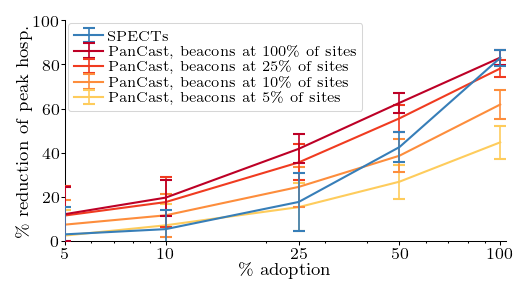

In [84]:
def plot_adoption_vs_relative_reduction(*, country, area, mode, ps_adoption, beta_dispersion=1.0, beacon_proportions=1.0,
                            beacon_mode='visit_freq', p_recall=0.1, plot_rt=True, plot_pmf=False, commithash=None):
    
    if commithash:
        commitstr = f'-{commithash}'
    else:
        commitstr = ''

        
    plot_filename = f'reduction-{mode}-{country}-{area}-beacon_mode={beacon_mode}'

    paths = [ [f'spect-tracing-{country}-{area}{commitstr}/'
                      f'spect-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beta_dispersion={beta_dispersion}'
                      '.pk' for p_adoption in ps_adoption]
            ]
    titles = ['SPECTs']
    
    for beacon_proportion in beacon_proportions:
        paths.append([f'pancast-tracing-{country}-{area}{commitstr}/'
                      f'pancast-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-p_recall={p_recall}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-beta_dispersion={beta_dispersion}'
                      '.pk' for p_adoption in ps_adoption])
        titles.append(f'PanCast, beacons at {int(beacon_proportion*100)}\% of sites')


    baseline_path = (f'spect-tracing-{country}-{area}{commitstr}/'
                      f'spect-tracing-{country}-{area}'
                      f'-p_adoption=0.0'
                      f'-beta_dispersion={beta_dispersion}.pk')


    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   titles=titles,
                                   mode=mode,   # Allowed values ['cumu_infected', 'hosp', 'dead']
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double',
                                   legend_is_left=True)

              
plot_adoption_vs_relative_reduction(
    country='GER', 
    area='TU', 
    mode='hosp',   # Allowed values ['cumu_infected', 'hosp', 'dead']
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],#, 0.02],
    beacon_mode='visit_freq',
    plot_rt=True, 
    plot_pmf=False,
    commithash=commithash
)

## ROC

Loaded previously extracted data.
-0.010   TP 183.23 FP 25034.89  TN  0.00  FN  0.00
0.000   TP 183.22 FP 25032.61  TN  2.28  FN  0.01
0.010   TP 161.10 FP 13720.46  TN 11314.43  FN 22.13
0.020   TP 153.81 FP 11139.69  TN 13895.20  FN 29.42
0.030   TP 147.76 FP 9760.08  TN 15274.81  FN 35.47
0.040   TP 142.55 FP 8780.37  TN 16254.52  FN 40.68
0.050   TP 136.84 FP 7959.19  TN 17075.70  FN 46.39
0.060   TP 130.61 FP 7233.37  TN 17801.52  FN 52.62
0.070   TP 124.70 FP 6574.04  TN 18460.85  FN 58.53
0.080   TP 118.61 FP 5969.72  TN 19065.17  FN 64.62
0.090   TP 113.16 FP 5414.45  TN 19620.44  FN 70.07
0.100   TP 106.95 FP 4904.72  TN 20130.17  FN 76.28
0.110   TP 100.97 FP 4443.49  TN 20591.40  FN 82.26
0.120   TP 95.43 FP 4019.59  TN 21015.30  FN 87.80
0.130   TP 89.71 FP 3627.31  TN 21407.58  FN 93.52
0.140   TP 84.19 FP 3272.72  TN 21762.17  FN 99.04
0.150   TP 78.54 FP 2947.04  TN 22087.85  FN 104.69
0.160   TP 73.42 FP 2647.10  TN 22387.79  FN 109.81
0.170   TP 68.28 FP 2378.28  TN 22

Loaded previously extracted data.
-0.010   TP 161.89 FP 24245.51  TN  0.00  FN  0.00
0.000   TP 161.88 FP 24243.28  TN  2.23  FN  0.01
0.010   TP 142.82 FP 14825.06  TN 9420.45  FN 19.07
0.020   TP 135.12 FP 11942.95  TN 12302.56  FN 26.77
0.030   TP 128.86 FP 10077.26  TN 14168.25  FN 33.03
0.040   TP 123.11 FP 8731.12  TN 15514.39  FN 38.78
0.050   TP 117.33 FP 7688.50  TN 16557.01  FN 44.56
0.060   TP 111.52 FP 6843.66  TN 17401.85  FN 50.37
0.070   TP 106.32 FP 6127.75  TN 18117.76  FN 55.57
0.080   TP 100.86 FP 5504.07  TN 18741.44  FN 61.03
0.090   TP 95.43 FP 4951.49  TN 19294.02  FN 66.46
0.100   TP 90.06 FP 4451.93  TN 19793.58  FN 71.83
0.110   TP 84.74 FP 4004.22  TN 20241.29  FN 77.15
0.120   TP 79.65 FP 3597.54  TN 20647.97  FN 82.24
0.130   TP 74.55 FP 3233.87  TN 21011.64  FN 87.34
0.140   TP 69.23 FP 2897.62  TN 21347.89  FN 92.66
0.150   TP 64.65 FP 2592.67  TN 21652.84  FN 97.24
0.160   TP 59.78 FP 2320.77  TN 21924.74  FN 102.11
0.170   TP 54.92 FP 2067.83  TN 22177.

Loaded previously extracted data.
-0.010   TP 186.21 FP 29269.87  TN  0.00  FN  0.00
0.000   TP 186.20 FP 29267.00  TN  2.87  FN  0.01
0.010   TP 162.20 FP 19413.11  TN 9856.76  FN 24.01
0.020   TP 151.43 FP 15914.40  TN 13355.47  FN 34.78
0.030   TP 141.73 FP 13387.96  TN 15881.91  FN 44.48
0.040   TP 133.03 FP 11395.13  TN 17874.74  FN 53.18
0.050   TP 124.31 FP 9775.57  TN 19494.30  FN 61.90
0.060   TP 116.26 FP 8437.61  TN 20832.26  FN 69.95
0.070   TP 108.66 FP 7322.18  TN 21947.69  FN 77.55
0.080   TP 101.63 FP 6381.38  TN 22888.49  FN 84.58
0.090   TP 94.48 FP 5577.27  TN 23692.60  FN 91.73
0.100   TP 87.68 FP 4888.04  TN 24381.83  FN 98.53
0.110   TP 81.28 FP 4297.76  TN 24972.11  FN 104.93
0.120   TP 74.68 FP 3773.78  TN 25496.09  FN 111.53
0.130   TP 68.68 FP 3318.59  TN 25951.28  FN 117.53
0.140   TP 62.63 FP 2914.77  TN 26355.10  FN 123.58
0.150   TP 57.12 FP 2566.87  TN 26703.00  FN 129.09
0.160   TP 52.17 FP 2255.87  TN 27014.00  FN 134.04
0.170   TP 47.34 FP 1982.33  TN 

Loaded previously extracted data.
-0.010   TP 177.50 FP 29565.46  TN  0.00  FN  0.00
0.000   TP 177.47 FP 29562.86  TN  2.60  FN  0.03
0.010   TP 152.09 FP 20814.58  TN 8750.88  FN 25.41
0.020   TP 139.05 FP 17378.22  TN 12187.24  FN 38.45
0.030   TP 127.83 FP 14693.81  TN 14871.65  FN 49.67
0.040   TP 116.23 FP 12477.98  TN 17087.48  FN 61.27
0.050   TP 105.53 FP 10614.56  TN 18950.90  FN 71.97
0.060   TP 95.52 FP 9016.35  TN 20549.11  FN 81.98
0.070   TP 86.36 FP 7661.59  TN 21903.87  FN 91.14
0.080   TP 77.66 FP 6498.48  TN 23066.98  FN 99.84
0.090   TP 69.39 FP 5503.70  TN 24061.76  FN 108.11
0.100   TP 62.34 FP 4662.47  TN 24902.99  FN 115.16
0.110   TP 55.36 FP 3935.46  TN 25630.00  FN 122.14
0.120   TP 49.09 FP 3318.95  TN 26246.51  FN 128.41
0.130   TP 43.60 FP 2793.41  TN 26772.05  FN 133.90
0.140   TP 38.06 FP 2350.24  TN 27215.22  FN 139.44
0.150   TP 33.15 FP 1978.66  TN 27586.80  FN 144.35
0.160   TP 28.67 FP 1657.76  TN 27907.70  FN 148.83
0.170   TP 24.77 FP 1387.75  TN 

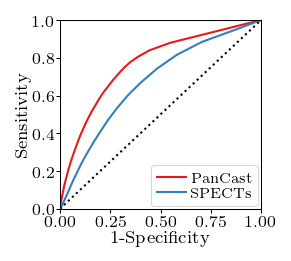

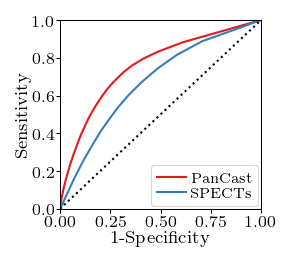

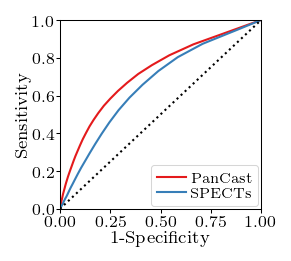

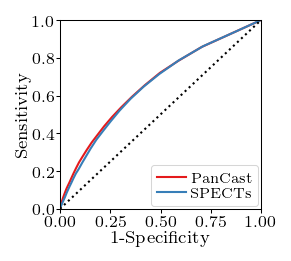

In [83]:
def plot_roc(*, country, area, p_adoption, beta_dispersions, commithash=None):
    if commithash:
        commitstr = f'-{commithash}'
    else:
        commitstr = ''
    
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
         f'beacon-environment-{country}-{area}-beta_dispersion={beta_dispersion}' : [
            Plot(label='tracing-stats', 
                path=(f'beacon-environment-{country}-{area}{commitstr}/'
                      f'beacon-environment-{country}-{area}'
                      f'-beacon=all'
                      f'-p_adoption={p_adoption}'
                      f'-beta_dispersion={beta_dispersion}'
                      '.pk')),
        ] for beta_dispersion in beta_dispersions
    }
    
    for plot_filename, plots in plots.items():
        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')
    
        # plots
        plotter = Plotter()

        plotter.plot_roc_curve(
            titles=labels,
            summaries=None,
            paths=paths,
            filename=plot_filename, 
            action='isolate',
            figsize=(2.0, 1.8), 
#             figsize=(1.8, 1.6), 
            figformat='neurips-double',
            use_medical_labels=True)

        
plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=1.0,
    beta_dispersions=[20.0, 10.0, 5.0, 2.0],
    commithash=commithash
)
    


In [ ]:
# Crop pdf margins
# !bash crop_pdfs.sh plots/beacon-environment-*.pdf


# Heat maps

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

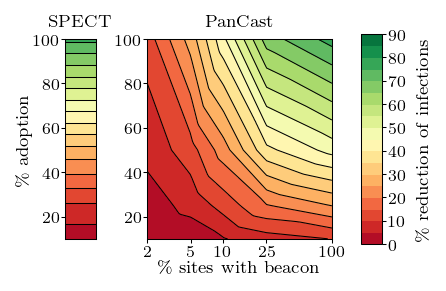

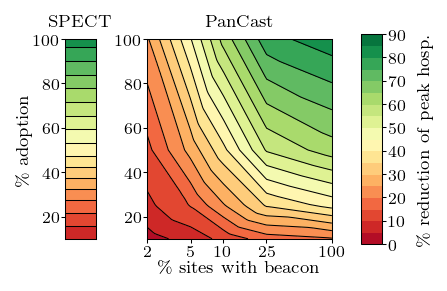

In [85]:
def plot_relative_quantity_heatmap(*, country, area, mode,
    ps_adoption, beta_dispersion, beacon_proportions, 
    beacon_mode, p_recall, interpolate, cmap):
    
    filename = (
        f'relative-{mode}-heatmap-beacon_mode={beacon_mode}'
    )
    
    baseline_path = (
        f'spect-tracing-{country}-{area}-{commithash}/'
        f'spect-tracing-{country}-{area}'
        f'-p_adoption=0.0'
        f'-beta_dispersion={beta_dispersion}.pk')
    
    # pair of list of tuples (x, y, path)
    paths = (
        # spect
        [(None, p_adoption, 
         (f'spect-tracing-{country}-{area}-{commithash}/'
          f'spect-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption],
        
        # pancast
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-p_recall={p_recall}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode={beacon_mode}'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions]
    )

    # plots
    plotter = Plotter()
    plotter.relative_quantity_heatmap(
        xlabel=r'\% sites with beacon',
        ylabel=r'\% adoption',
        path_labels=['SPECT', 'PanCast'],
        paths=paths, 
        mode=mode,
        baseline_path=baseline_path,
        filename=filename, 
#         figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figsize=(2.8, 2.0), 
        figformat='neurips-double',
        interpolate=interpolate,
        width_ratio=6,
        cmap=cmap,
    )

    
for mode in ["cumu_infected", "hosp"]:

    plot_relative_quantity_heatmap(
        mode=mode,
        country='GER', 
        area='TU', 
        ps_adoption=[0.1, 0.25, 0.5, 1.0],
        beta_dispersion=1.0,
        beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
        beacon_mode='visit_freq',
        p_recall=0.1,
        interpolate='linear',
        cmap=plt.cm.RdYlGn,
    )

        

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

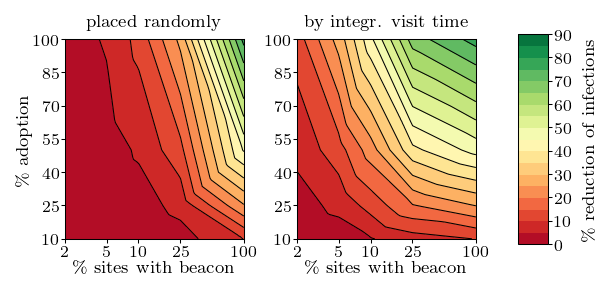

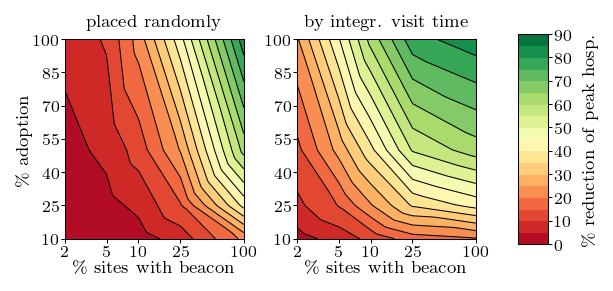

In [99]:
def plot_relative_quantity_heatmap_beacon_mode(*, country, area, mode,
    ps_adoption, beta_dispersion, beacon_proportions, 
    p_recall, interpolate, cmap):
    
    filename = (
        f'relative-{mode}-heatmap-pancast'
    )
    
    baseline_path = (
        f'spect-tracing-{country}-{area}-{commithash}/'
        f'spect-tracing-{country}-{area}'
        f'-p_adoption=0.0'
        f'-beta_dispersion={beta_dispersion}.pk')
    
    # pair of list of tuples (x, y, path)
    paths = (
        # spect
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-p_recall={p_recall}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=random'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions],
        
        # pancast
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-p_recall={p_recall}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=visit_freq'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions]
    )

    # plots
    plotter = Plotter()
    plotter.relative_quantity_heatmap(
        xlabel=r'\% sites with beacon',
        ylabel=r'\% adoption',
        path_labels=['placed randomly', 'by integr. visit time'],
        paths=paths, 
        mode=mode,
        baseline_path=baseline_path,
        filename=filename, 
#         figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figsize=(4.0, 2.0), 
        figformat='neurips-double',
        interpolate=interpolate,
        width_ratio=1,
        cmap=cmap,
    )

    
for mode in ["cumu_infected", "hosp"]:
    plot_relative_quantity_heatmap_beacon_mode(
        mode=mode,
        country='GER', 
        area='TU', 
        ps_adoption=[0.1, 0.25, 0.5, 1.0],
        beta_dispersion=1.0,
        beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
        p_recall=0.1,
        interpolate='linear',
        cmap=plt.cm.RdYlGn,
    )
        

In [100]:
!bash crop_pdfs.sh plots/relative-*.pdf


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
